<a href="https://colab.research.google.com/github/saugatp/research_project_saugat/blob/main/ArtBC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algorithm part

This is the algorithm for this research. Code downloaded from github and various other data sources.

In [16]:
!pip install numpy
!pip install scipy
!pip install sklearn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [17]:
import numpy as np

from scipy import optimize

from abc import ABCMeta
from abc import abstractmethod
from six import add_metaclass


@add_metaclass(ABCMeta)
class ObjectiveFunction(object):

    def __init__(self, name, dim, minf, maxf):
        self.name = name
        self.dim = dim
        self.minf = minf
        self.maxf = maxf

    def sample(self):
        return np.random.uniform(low=self.minf, high=self.maxf, size=self.dim)

    def custom_sample(self):
        return np.repeat(self.minf, repeats=self.dim) \
               + np.random.uniform(low=0, high=1, size=self.dim) *\
               np.repeat(self.maxf - self.minf, repeats=self.dim)

    @abstractmethod
    def evaluate(self, x):
        pass

In [18]:
import numpy as np

from copy import deepcopy
from abc import ABCMeta
from six import add_metaclass


@add_metaclass(ABCMeta)
class ArtificialBee(object):

    TRIAL_INITIAL_DEFAULT_VALUE = 0
    INITIAL_DEFAULT_PROBABILITY = 0.0

    def __init__(self, obj_function):
        self.pos = obj_function.custom_sample()
        self.obj_function = obj_function
        self.minf = obj_function.minf
        self.maxf = obj_function.maxf
        self.fitness = obj_function.evaluate(self.pos)
        self.trial = ArtificialBee.TRIAL_INITIAL_DEFAULT_VALUE
        self.prob = ArtificialBee.INITIAL_DEFAULT_PROBABILITY

    def evaluate_boundaries(self, pos):
        if (pos < self.minf).any() or (pos > self.maxf).any():
            pos[pos > self.maxf] = self.maxf
            pos[pos < self.minf] = self.minf
        return pos

    def update_bee(self, pos, fitness):
        if fitness <= self.fitness:
            self.pos = pos
            self.fitness = fitness
            self.trial = 0
        else:
            self.trial += 1

    def reset_bee(self, max_trials):
        if self.trial >= max_trials:
            self.__reset_bee()

    def __reset_bee(self):
        self.pos = self.obj_function.custom_sample()
        self.fitness = self.obj_function.evaluate(self.pos)
        self.trial = ArtificialBee.TRIAL_INITIAL_DEFAULT_VALUE
        self.prob = ArtificialBee.INITIAL_DEFAULT_PROBABILITY

In [19]:
class EmployeeBee(ArtificialBee):

    def explore(self, max_trials):
        if self.trial <= max_trials:
            component = np.random.choice(self.pos)
            phi = np.random.uniform(low=-1, high=1, size=len(self.pos))
            n_pos = self.pos + (self.pos - component) * phi
            n_pos = self.evaluate_boundaries(n_pos)
            n_fitness = self.obj_function.evaluate(n_pos)
            self.update_bee(n_pos, n_fitness)

    def get_fitness(self):
        return 1 / (1 + self.fitness) if self.fitness >= 0 else 1 + np.abs(self.fitness)

    def compute_prob(self, max_fitness):
        self.prob = self.get_fitness() / max_fitness

In [20]:
class OnLookerBee(ArtificialBee):

    def onlook(self, best_food_sources, max_trials):
        candidate = np.random.choice(best_food_sources)
        self.__exploit(candidate.pos, candidate.fitness, max_trials)

    def __exploit(self, candidate, fitness, max_trials):
        if self.trial <= max_trials:
            component = np.random.choice(candidate)
            phi = np.random.uniform(low=-1, high=1, size=len(candidate))
            n_pos = candidate + (candidate - component) * phi
            n_pos = self.evaluate_boundaries(n_pos)
            n_fitness = self.obj_function.evaluate(n_pos)

            if n_fitness <= fitness:
                self.pos = n_pos
                self.fitness = n_fitness
                self.trial = 0
            else:
                self.trial += 1

In [21]:
class ArtBC(object):
    def __init__(self, obj_function, colony_size=30, n_iter=100, max_trials=100):
        # Algorithm parameters
        self.colony_size = colony_size
        self.obj_function = obj_function
        self.n_iter = n_iter
        self.max_trials = max_trials

        # Optimization variables
        self.optimal_solution = None
        self.optimality_tracking = []

    def __reset_algorithm(self):
        # Reset optimization variables
        self.optimal_solution = None
        self.optimality_tracking = []

    def __update_optimality_tracking(self):
        # Update optimality tracking with current optimal solution's fitness
        self.optimality_tracking.append(self.optimal_solution.fitness)

    def __update_optimal_solution(self):
        # Update optimal solution based on the best fitness among employees and onlookers
        n_optimal_solution = min(self.onlooker_bees + self.employee_bees, key=lambda bee: bee.fitness)
        if not self.optimal_solution:
            self.optimal_solution = deepcopy(n_optimal_solution)
        else:
            if n_optimal_solution.fitness < self.optimal_solution.fitness:
                self.optimal_solution = deepcopy(n_optimal_solution)

    def __initialize_employees(self):
        # Initialize employee bees
        self.employee_bees = [EmployeeBee(self.obj_function) for _ in range(self.colony_size // 2)]

    def __initialize_onlookers(self):
        # Initialize onlooker bees
        self.onlooker_bees = [OnLookerBee(self.obj_function) for _ in range(self.colony_size // 2)]

    def __employee_bees_phase(self):
        # Perform exploration phase for employee bees
        map(lambda bee: bee.explore(self.max_trials), self.employee_bees)

    def __calculate_probabilities(self):
        # Calculate probabilities for employee bees based on fitness
        sum_fitness = sum(map(lambda bee: bee.get_fitness(), self.employee_bees))
        map(lambda bee: bee.compute_prob(sum_fitness), self.employee_bees)

    def __select_best_food_sources(self):
        # Select best food sources (employee bees) based on probabilities
        self.best_food_sources = filter(lambda bee: bee.prob > np.random.uniform(low=0, high=1), self.employee_bees)
        while not self.best_food_sources:
            self.best_food_sources = filter(lambda bee: bee.prob > np.random.uniform(low=0, high=1), self.employee_bees)

    def __onlooker_bees_phase(self):
        # Perform onlooker phase where onlooker bees choose food sources based on probabilities
        map(lambda bee: bee.onlook(self.best_food_sources, self.max_trials), self.onlooker_bees)

    def __scout_bees_phase(self):
        # Perform scout phase where bees that haven't improved reset and explore again
        map(lambda bee: bee.reset_bee(self.max_trials), self.onlooker_bees + self.employee_bees)

    def optimize(self):
        # Run the ABC optimization algorithm
        self.__reset_algorithm()
        self.__initialize_employees()
        self.__initialize_onlookers()

        for itr in range(self.n_iter):
            self.__employee_bees_phase()
            self.__update_optimal_solution()

            self.__calculate_probabilities()
            self.__select_best_food_sources()

            self.__onlooker_bees_phase()
            self.__scout_bees_phase()

            self.__update_optimal_solution()
            self.__update_optimality_tracking()


In [22]:
@add_metaclass(ABCMeta)
class PartitionalClusteringObjectiveFunction(ObjectiveFunction):

    def __init__(self, dim, n_clusters, data):
        super(PartitionalClusteringObjectiveFunction, self)\
            .__init__('PartitionalClusteringObjectiveFunction', dim, 0.0, 1.0)
        self.n_clusters = n_clusters
        self.centroids = {}
        self.data = data

    def decode(self, x):
        centroids = x.reshape(self.n_clusters,  self.data.shape[1])
        self.centroids = dict(enumerate(centroids))

    @abstractmethod
    def evaluate(self, x):
        pass

class SumOfSquaredErrors(PartitionalClusteringObjectiveFunction):

    def __init__(self, dim, n_clusters, data):
        super(SumOfSquaredErrors, self).__init__(dim, n_clusters, data)
        self.name = 'SumOfSquaredErrors'

    def evaluate(self, x):
        self.decode(x)

        clusters = {key: [] for key in self.centroids.keys()}
        for instance in self.data:
            distances = [np.linalg.norm(self.centroids[idx] - instance)
                         for idx in self.centroids]
            clusters[np.argmin(distances)].append(instance)

        sum_of_squared_errors = 0.0
        for idx in self.centroids:
            distances = [np.linalg.norm(self.centroids[idx] - instance)
                         for instance in clusters[idx]]
            sum_of_squared_errors += sum(np.power(distances, 2))
        return sum_of_squared_errors



```
# This is formatted as code
```

# Testing Part
In this section, I test the algorithm with different dataset, generating reports and charts.

In [23]:
!pip install ucimlrepo
!pip install matplotlib

# Choose between which dataset to use

In [24]:
# Replace the value below  with 'iris', 'wine', 'cancer', 'credit', 'sample_1' and 'sample_2' to test each dataset
loading_data='iris'

In [25]:
import matplotlib.pyplot as plt

from abc import ABC

from sklearn.datasets import load_iris
from sklearn.datasets import load_wine
from sklearn.datasets import load_breast_cancer

from sklearn.preprocessing import MinMaxScaler

from sklearn.datasets import make_blobs
from ucimlrepo import fetch_ucirepo

if(loading_data=='wine'):
    orig_data = load_wine()
    print(orig_data)
    data = MinMaxScaler().fit_transform(orig_data['data'][:, [1,3]])
    target = orig_data['target']
    no_of_clusters = 3
elif(loading_data=='iris'):
    orig_data = load_iris()
    data = MinMaxScaler().fit_transform(orig_data['data'][:, [1,3]])
    target = orig_data['target']
    no_of_clusters = 3
elif(loading_data=='cancer'):
    orig_data = load_breast_cancer()
    data = MinMaxScaler().fit_transform(orig_data['data'][:, [1,3]])
    target = orig_data['target']
    no_of_clusters = 2
elif(loading_data=='credit'):
    statlog_credit_approval = fetch_ucirepo(id=144)
    orig_data = statlog_credit_approval.data.features[['Attribute2','Attribute5']]
    data = MinMaxScaler().fit_transform(orig_data)
    targets=statlog_credit_approval.data.targets
    target = targets['class'].to_list()
    no_of_clusters = 2
elif(loading_data=='sample_1'):
    data, target = make_blobs(n_samples=1500, centers=3, n_features=2, random_state=42)
    no_of_clusters=3
elif(loading_data=='sample_2'):
    data, target = make_blobs(n_samples=3000, centers=3, n_features=2, random_state=42)
    no_of_clusters=3


# Testing our algorithm
Parameter tuning requires updating the following variables below:
```
colony_size
n_iter
max_trials
```



In [26]:
import time

start_time_abc = time.time()

objective_function = SumOfSquaredErrors(dim=no_of_clusters*2, n_clusters=no_of_clusters, data=data)

optimizer = ArtBC(obj_function=objective_function, colony_size=30,
                n_iter=300, max_trials=100)
optimizer.optimize()
def decode_centroids(centroids, n_clusters, data):
    return centroids.reshape(n_clusters, data.shape[1])

centroids = dict(enumerate(decode_centroids(optimizer.optimal_solution.pos,
                                            n_clusters=no_of_clusters, data=data)))

def assign_centroid(centroids, point):
    distances = [np.linalg.norm(point - centroids[idx]) for idx in centroids]
    return np.argmin(distances)

custom_tgt = []
for instance in data:
    custom_tgt.append(assign_centroid(centroids, instance))

end_time_abc = time.time()
# Calculate the time difference
execution_time_abc = end_time_abc - start_time_abc


# Testing K-Means clustering

In [27]:
from sklearn.cluster import KMeans
# Create a NumPy array from the data for KMeans clustering
X = np.array(data)

start_time = time.time()

# Fit KMeans clustering model
kmeans = KMeans(n_clusters=no_of_clusters)
kmeans.fit(X)

# Get cluster labels from KMeans
kmeans_labels = kmeans.labels_
end_time = time.time()
# Calculate the time difference
execution_time = end_time - start_time


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [28]:
from sklearn.cluster import AgglomerativeClustering
start_time_ag = time.time()

ward_model = AgglomerativeClustering(n_clusters=no_of_clusters, linkage='ward')
ward_labels = ward_model.fit_predict(X)
end_time_ag = time.time()
execution_time_ag = end_time_ag - start_time_ag


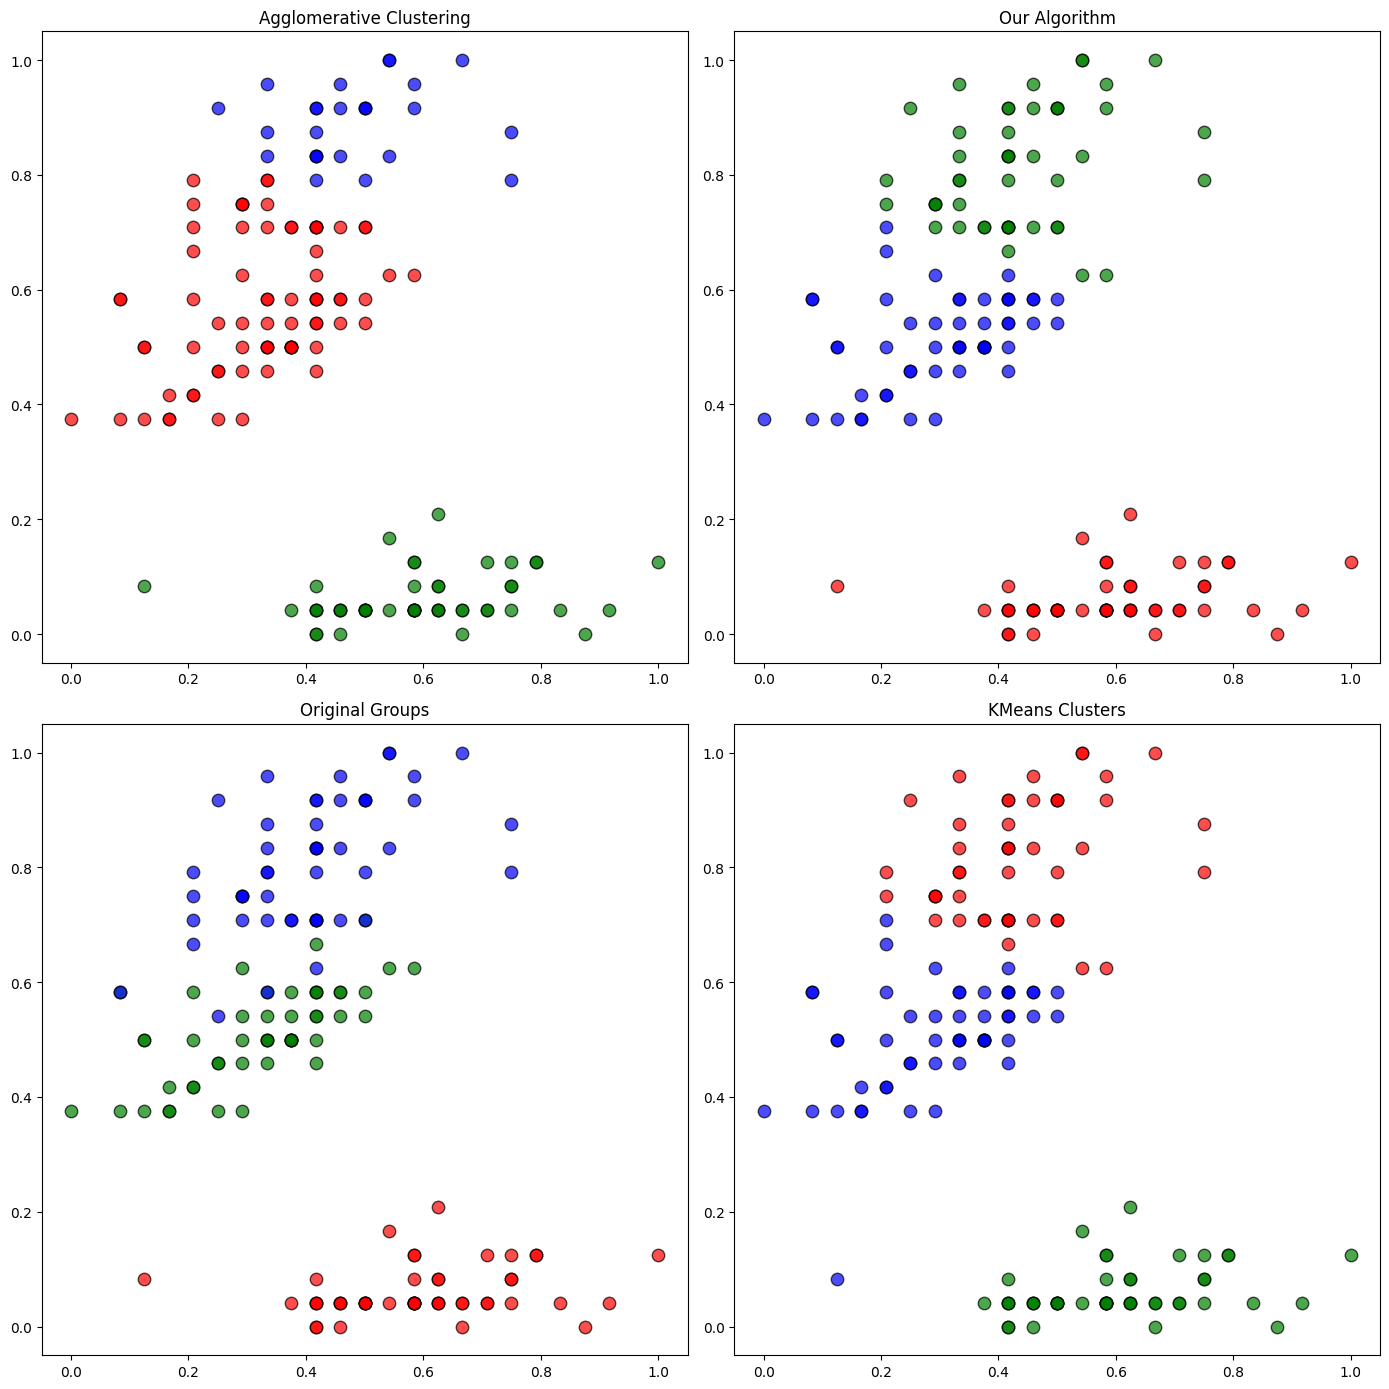

In [29]:
colors = ['r', 'g', 'b']
# Create a figure with two rows and two columns
fig, axs = plt.subplots(2, 2, figsize=(14, 14))

# Plot the first set of data on the first subplot (first row)
axs[0, 0].set_title('Agglomerative Clustering')
for instance, tgt in zip(data, ward_labels):
    axs[0, 0].scatter(instance[0], instance[1], s=80, edgecolor='k',
                      alpha=0.7, color=colors[tgt], label=tgt)

# Plot the second set of data on the second subplot (first row)
axs[0, 1].set_title('Our Algorithm')
for instance, tgt in zip(data, custom_tgt):
    axs[0, 1].scatter(instance[0], instance[1], s=80, edgecolor='k',
                      alpha=0.7, color=colors[tgt], label=tgt)

# Plot the third set of data on the third subplot (second row)
axs[1, 0].set_title('Original Groups')
for instance, tgt in zip(data, target):
    axs[1, 0].scatter(instance[0], instance[1], s=80, edgecolor='k', alpha=0.7, color=colors[tgt], label=tgt)


# Plot KMeans clusters on the fourth subplot (second row)
axs[1, 1].set_title('KMeans Clusters')
for instance, label in zip(data, kmeans_labels):
    axs[1, 1].scatter(instance[0], instance[1], s=80,
                     edgecolor='k', alpha=0.7, color=colors[label], label=label)

# Adjust layout for better spacing
plt.tight_layout()
# Show the plot
plt.show()


The output for this gives us the ARI value as well as time taken by each algorithm.

In [30]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

ari_k = adjusted_rand_score(target, kmeans_labels)
nmi_k = normalized_mutual_info_score(target, kmeans_labels)
print("K-means")
print(f"Adjusted Rand Index: {ari_k}")
print(f"Normalized Mutual Information: {nmi_k}")
print(" ")

ari_c = adjusted_rand_score(target, custom_tgt)
nmi_c = normalized_mutual_info_score(target, custom_tgt)
print("Artificial Bee Colony")
print(f"Adjusted Rand Index: {ari_c}")
print(f"Normalized Mutual Information: {nmi_c}")
print(" ")

ari_w = adjusted_rand_score(target, ward_labels)
nmi_w = normalized_mutual_info_score(target, ward_labels)
print("Agglomerative")
print(f"Adjusted Rand Index: {ari_w}")
print(f"Normalized Mutual Information: {nmi_w}")
print(" ")

from tabulate import tabulate

# Assuming kmeans_labels, custom_tgt, and ward_labels are the arrays you want to print
data = {'KMeans Labels': kmeans_labels, 'Custom Target': custom_tgt, 'Ward Labels': ward_labels}
table = tabulate(data, headers='keys', tablefmt='pretty')


# Print the result
print(f"Execution Time for ABC: {execution_time_abc} seconds")
print(f"Execution Time for Kmeans: {execution_time} seconds")
print(f"Execution Time for Agglomerative: {execution_time_ag} seconds")

K-means
Adjusted Rand Index: 0.7971747056191755
Normalized Mutual Information: 0.773824913322169
 
Artificial Bee Colony
Adjusted Rand Index: 0.8176016452576428
Normalized Mutual Information: 0.8037974551773084
 
Agglomerative
Adjusted Rand Index: 0.644447235392006
Normalized Mutual Information: 0.7441744155974127
 
Execution Time for ABC: 0.4938535690307617 seconds
Execution Time for Kmeans: 0.06190991401672363 seconds
Execution Time for Agglomerative: 0.00722956657409668 seconds
